In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.random_projection import GaussianRandomProjection
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, homogeneity_score, silhouette_score, classification_report

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
SEED=2023

df1 = pd.read_csv('electricity-normalized.csv')
df1['class'] = df1['class'].apply(lambda x: 1 if x=='UP' else 0)
df2 = pd.read_csv('wine.csv')
df1_X = df1[['period', 'nswprice', 'nswdemand', 'vicprice',
       'vicdemand', 'transfer']]
df1_y = df1['class']

df2_X = df2[['Alcohol', 'Malic_acid', 'Ash', 'Alcalinity_of_ash',
       'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols',
       'Proanthocyanins', 'Color_intensity', 'Hue', 'Od_Hod_of_diluted_wines',
       'Proline']]
df2_y = df2['class']

min_max_scaler = MinMaxScaler()

df1_X = min_max_scaler.fit_transform(df1_X)
df2_X = min_max_scaler.fit_transform(df2_X)

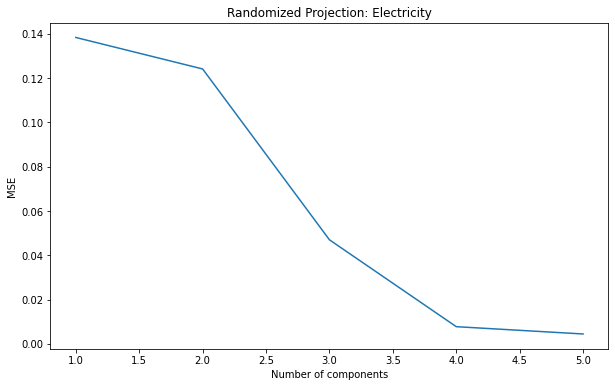

CPU times: user 482 ms, sys: 158 ms, total: 640 ms
Wall time: 207 ms


In [5]:
%%time
X = df1_X

dims = np.arange(1, X.shape[1])
errors = []
for dim in dims:
    ica = GaussianRandomProjection(n_components=dim, random_state=SEED)
    x_prime = ica.fit_transform(X)
    A = np.linalg.pinv(ica.components_.T)
    reconstructed = np.dot(x_prime, A)
    errors.append(mean_squared_error(X, reconstructed)) 

plt.figure(figsize=(10,6))
plt.plot(dims, errors)
plt.xlabel("Number of components")
plt.ylabel("MSE")
plt.title('Randomized Projection: Electricity')
plt.show()

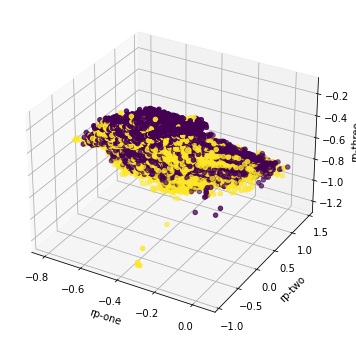

In [6]:
comp = 4

ica = GaussianRandomProjection(n_components=comp, random_state=SEED)
ica_result1 = ica.fit_transform(X)

ax = plt.figure(figsize=(10,6)).add_subplot(projection='3d')
ax.scatter(
    xs=ica_result1[:, 0], 
    ys=ica_result1[:, 1], 
    zs=ica_result1[:, 2], 
    c=df1_y.values
)
ax.set_xlabel('rp-one')
ax.set_ylabel('rp-two')
ax.set_zlabel('rp-three')
plt.show()

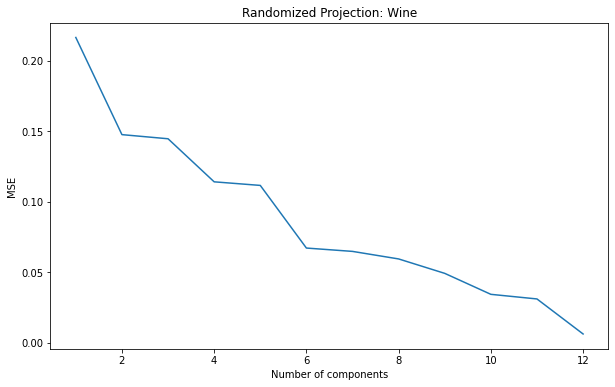

CPU times: user 457 ms, sys: 162 ms, total: 619 ms
Wall time: 187 ms


In [7]:
%%time
X = df2_X

dims = np.arange(1, X.shape[1])
errors = []
for dim in dims:
    ica = GaussianRandomProjection(n_components=dim, random_state=SEED)
    x_prime = ica.fit_transform(X)
    A = np.linalg.pinv(ica.components_.T)
    reconstructed = np.dot(x_prime, A)
    errors.append(mean_squared_error(X, reconstructed)) 

plt.figure(figsize=(10,6))
plt.plot(dims, errors)
plt.xlabel("Number of components")
plt.ylabel("MSE")
plt.title('Randomized Projection: Wine')
plt.show()

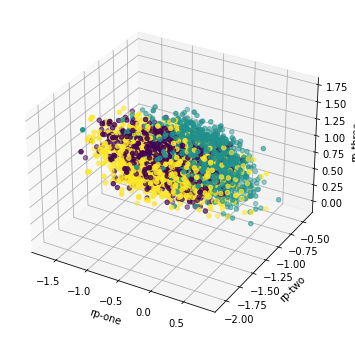

In [8]:
comp = 6

ica = GaussianRandomProjection(n_components=comp, random_state=SEED)
ica_result2 = ica.fit_transform(X)

ax = plt.figure(figsize=(10,6)).add_subplot(projection='3d')
ax.scatter(
    xs=ica_result2[:, 0], 
    ys=ica_result2[:, 1], 
    zs=ica_result2[:, 2], 
    c=df2_y.values
)
ax.set_xlabel('rp-one')
ax.set_ylabel('rp-two')
ax.set_zlabel('rp-three')
plt.show()

# K Means

100%|██████████| 18/18 [09:05<00:00, 30.32s/it]


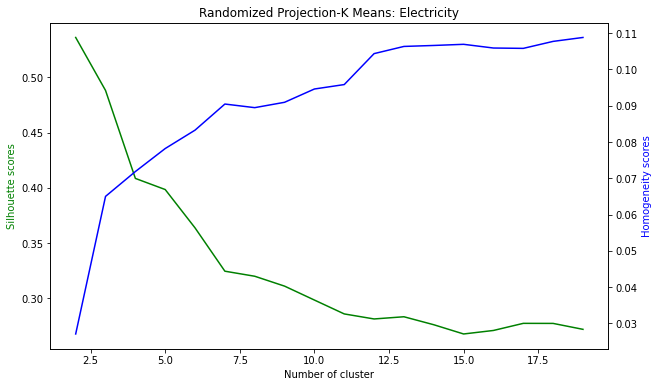

In [7]:
X = ica_result1.copy()
y = df1_y.copy()

clusters = np.arange(2, 20)
silh_scores = []
homog_scores = []
for cluster in tqdm(clusters):
    kmeans = KMeans(n_clusters=cluster, max_iter=1000, n_init=5, random_state=SEED).fit(X)
    pred = kmeans.predict(X)
    silh_scores.append(silhouette_score(X, pred, metric='euclidean'))
    homog_scores.append(homogeneity_score(y, pred))

fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()
ax1.plot(clusters, silh_scores, 'g-')
ax2.plot(clusters, homog_scores, 'b-')

ax1.set_xlabel('Number of cluster')
ax1.set_ylabel('Silhouette scores', color='g')
ax2.set_ylabel('Homogeneity scores', color='b')
plt.title('Randomized Projection-K Means: Electricity')

plt.show()


100%|██████████| 18/18 [00:10<00:00,  1.76it/s]


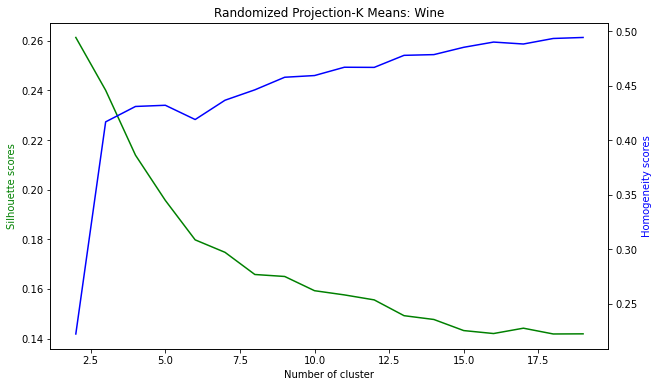

In [8]:
X = ica_result2.copy()
y = df2_y.copy()

clusters = np.arange(2, 20)
silh_scores = []
homog_scores = []
for cluster in tqdm(clusters):
    kmeans = KMeans(n_clusters=cluster, max_iter=1000, n_init=5, random_state=SEED).fit(X)
    pred = kmeans.predict(X)
    silh_scores.append(silhouette_score(X, pred, metric='euclidean'))
    homog_scores.append(homogeneity_score(y, pred))

fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()
ax1.plot(clusters, silh_scores, 'g-')
ax2.plot(clusters, homog_scores, 'b-')

ax1.set_xlabel('Number of cluster')
ax1.set_ylabel('Silhouette scores', color='g')
ax2.set_ylabel('Homogeneity scores', color='b')
plt.title('Randomized Projection-K Means: Wine')

plt.show()


# EM

100%|██████████| 18/18 [14:08<00:00, 47.12s/it]


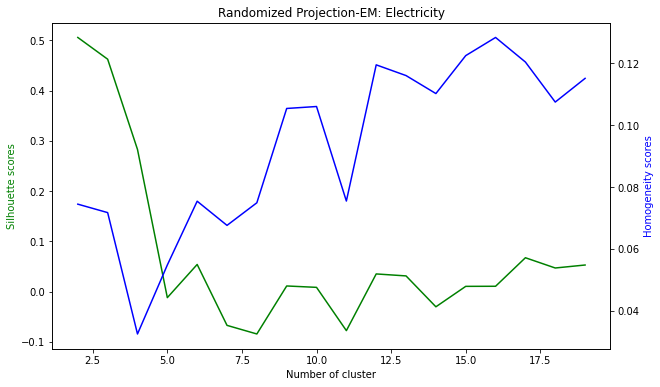

In [9]:
X = ica_result1.copy()
y = df1_y.copy()

clusters = np.arange(2, 20)

silh_scores = []
homog_scores = []

for cluster in tqdm(clusters):
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=SEED, 
                          n_init=5).fit(X)
    label = gmm.predict(X)
    silh_scores.append(silhouette_score(X, label, metric='euclidean'))
    homog_scores.append(homogeneity_score(y, label))

    
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()
ax1.plot(clusters, silh_scores, 'g-')
ax2.plot(clusters, homog_scores, 'b-')

ax1.set_xlabel('Number of cluster')
ax1.set_ylabel('Silhouette scores', color='g')
ax2.set_ylabel('Homogeneity scores', color='b')
plt.title('Randomized Projection-EM: Electricity')

plt.show()

100%|██████████| 18/18 [00:26<00:00,  1.46s/it]


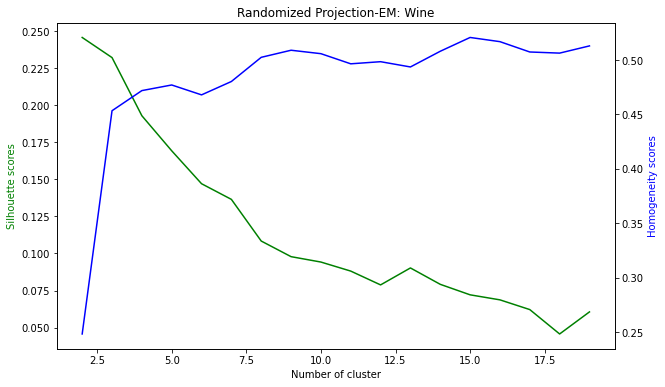

In [10]:
X = ica_result2.copy()
y = df2_y.copy()

clusters = np.arange(2, 20)

silh_scores = []
homog_scores = []

for cluster in tqdm(clusters):
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=SEED, 
                          n_init=5).fit(X)
    label = gmm.predict(X)
    silh_scores.append(silhouette_score(X, label, metric='euclidean'))
    homog_scores.append(homogeneity_score(y, label))

    
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()
ax1.plot(clusters, silh_scores, 'g-')
ax2.plot(clusters, homog_scores, 'b-')

ax1.set_xlabel('Number of cluster')
ax1.set_ylabel('Silhouette scores', color='g')
ax2.set_ylabel('Homogeneity scores', color='b')
plt.title('Randomized Projection-EM: Wine')

plt.show()

# NN

In [11]:
X_train, X_test, y_train, y_test = train_test_split(ica_result2, 
                                                    df2_y, 
                                                    test_size=0.33, 
                                                    random_state=SEED,
                                                    stratify=df2_y)


In [12]:
param_grid = {
    'hidden_layer_sizes': [(16,16), (16,32), (32, 32)],
    "alpha" : [0.1, 0.01, 0.001]
}
cv = GridSearchCV(MLPClassifier(), param_grid, cv=10, 
                         scoring='f1_weighted', n_jobs=-2)
cv.fit(X_train, y_train)

print(cv.best_estimator_)

MLPClassifier(alpha=0.1, hidden_layer_sizes=(32, 32))


In [14]:
nn = MLPClassifier(alpha=cv.best_estimator_.alpha, hidden_layer_sizes=cv.best_estimator_.hidden_layer_sizes)
nn.fit(X_train, y_train)

pred = nn.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.84      0.86      0.85       521
           2       0.82      0.82      0.82       664
           3       0.83      0.82      0.82       465

    accuracy                           0.83      1650
   macro avg       0.83      0.83      0.83      1650
weighted avg       0.83      0.83      0.83      1650

